# ML Lab 3 - Logistic Regression

### Выполнил: Концебалов Олег Сергеевич
### Группа: М8О-309Б-22


In [17]:
%pip install mplcyberpunk
%pip install catboost

Импортируем необходимые библиотеки

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler

In [19]:
pd.options.display.float_format = '{:.6f}'.format
pd.set_option("display.precision", 2)
pd.set_option('display.max_columns', None)

Класс линейной и логистической регрессии

In [20]:
from typing import Any


class LinearAndLogisticClassifier:
    def __init__(
        self,
        learning_rate: float = 0.01,
        n_iterations: int = 1000,
        logistic: bool = False
        ):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.logistic = logistic
        self.weights = None
        self.bias = None


    def _sigmoid(self, z: Any) -> Any:
        return 1 / (1 + np.exp(-z))


    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iterations):
            linear_model = np.dot(X, self.weights) + self.bias

            if self.logistic:
                y_predicted = self._sigmoid(linear_model)

                dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
                db = (1 / n_samples) * np.sum(y_predicted - y)
            else:
                y_predicted = linear_model

                dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
                db = (1 / n_samples) * np.sum(y_predicted - y)


            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db


    def predict(self, X: np.ndarray):
        linear_model = np.dot(X, self.weights) + self.bias

        if self.logistic:
            y_predicted = self._sigmoid(linear_model)

            return np.where(y_predicted >= 0.5, 1, 0)
        else:
            return np.where(linear_model >= 0.5, 1, 0)

Загружаем наши датасеты

In [21]:
PATH_TO_TEST = 'test.csv'
PATH_TO_TRAIN = 'train.csv'

In [22]:
train_df = pd.read_csv(PATH_TO_TRAIN)
test_df = pd.read_csv(PATH_TO_TEST)

temp_train_df = pd.read_csv(PATH_TO_TRAIN)
temp_test_df = pd.read_csv(PATH_TO_TEST)

Почистим данные - уберем дубликаты

In [23]:
train_df = train_df.dropna().drop_duplicates()

Посмотрим на наши данные. Начнем их анализировать

In [24]:
train_df.head(10)

,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,MaritalStatus,NumberOfDependents,HomeOwnershipStatus,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,LoanPurpose,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EmploymentStatus,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2010-06-26,27.000000,66829.000000,549.000000,17290.000000,60.000000,Divorced,1.000000,Rent,1095.000000,0.151985,2.000000,1.000000,0.168542,0.000000,Education,0.000000,23.000000,5.000000,2539.000000,247.000000,50072.000000,15005.000000,5569.083333,0.908289,4.000000,Employed,Associate,4.000000,35067.000000,0.257790,0.251465,508.970230,0.288013,0.000000,66.176500
1,1996-09-23,55.000000,172147.000000,850.000000,16110.000000,36.000000,Widowed,1.000000,Mortgage,211.000000,0.175693,3.000000,0.000000,0.141553,0.000000,Home,0.000000,27.000000,11.000000,844.000000,694.000000,91878.000000,64877.000000,14345.583333,0.797339,2.000000,Employed,High School,33.000000,27001.000000,0.086110,0.093173,514.675859,0.050585,1.000000,28.495737
2,2015-01-19,51.000000,300000.000000,850.000000,38436.000000,36.000000,Married,0.000000,Mortgage,546.000000,0.444605,3.000000,0.000000,0.030987,1.000000,Education,0.000000,21.000000,12.000000,12756.000000,651.000000,292300.000000,13918.000000,25000.000000,0.915945,3.000000,Employed,Bachelor,28.000000,278382.000000,0.108436,0.115443,1268.276385,0.072571,1.000000,34.488104
3,1981-05-12,25.000000,34683.000000,847.000000,19186.000000,48.000000,Married,0.000000,Other,153.000000,0.188452,7.000000,0.000000,0.379843,0.000000,Debt Consolidation,0.000000,27.000000,21.000000,1524.000000,529.000000,13070.000000,3846.000000,2890.250000,0.876416,3.000000,Employed,High School,0.000000,9224.000000,0.100686,0.112822,498.505187,0.225415,1.000000,36.910753
4,1995-05-07,55.000000,300000.000000,850.000000,30437.000000,48.000000,Single,2.000000,Rent,562.000000,0.273431,3.000000,1.000000,0.068659,0.000000,Debt Consolidation,0.000000,35.000000,9.000000,1973.000000,128.000000,33357.000000,351603.000000,25000.000000,0.888689,5.000000,Employed,Bachelor,31.000000,4502.000000,0.110437,0.089037,756.035156,0.052721,1.000000,31.347091
5,1997-05-12,21.000000,15000.000000,300.000000,29786.000000,48.000000,Single,4.000000,Rent,457.000000,0.191960,2.000000,0.000000,0.157591,0.000000,Auto,0.000000,16.000000,16.000000,1754.000000,1958.000000,99302.000000,45457.000000,1250.000000,0.567239,4.000000,Self-Employed,High School,0.000000,53845.000000,0.384786,0.404018,1259.904560,1.373524,0.000000,64.365309
6,1987-04-06,32.000000,300000.000000,850.000000,89073.000000,36.000000,Married,1.000000,Rent,82.000000,0.747773,2.000000,3.000000,0.312786,0.000000,Debt Consolidation,0.000000,24.000000,29.000000,10987.000000,563.000000,54801.000000,41891.000000,25000.000000,0.952190,4.000000,Employed,Associate,12.000000,12910.000000,0.159073,0.150327,3089.170736,0.126847,1.000000,38.910949
7,1989-05-09,38.000000,191474.000000,600.000000,6706.000000,72.000000,Married,0.000000,Rent,153.000000,0.266568,4.000000,0.000000,0.008319,0.000000,Auto,0.000000,18.000000,25.000000,17098.000000,1866.000000,18964.000000,47512.000000,15956.166667,0.734054,4.000000,Employed,High School,13.000000,4777.000000,0.231706,0.262994,186.024237,0.021247,1.000000,39.895288
8,1989-09-03,35.000000,15000.000000,403.000000,16291.000000,36.000000,Married,1.000000,Mortgage,960.000000,0.637950,6.000000,1.000000,0.044665,0.000000,Other,1.000000,20.000000,1.000000,5293.000000,435.000000,986905.000000,7276.000000,1250.000000,0.701853,6.000000,Employed,High School,11.000000,979629.000000,0.309791,0.279328,673.263227,1.306611,0.000000,67.814529
9,1985-02-28,34.000000,15000.000000,300.000000,20884.000000,60.000000,Married

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9529 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9529 non-null   object 
 1   Age                         9529 non-null   float64
 2   AnnualIncome                9529 non-null   float64
 3   CreditScore                 9529 non-null   float64
 4   LoanAmount                  9529 non-null   float64
 5   LoanDuration                9529 non-null   float64
 6   MaritalStatus               9529 non-null   object 
 7   NumberOfDependents          9529 non-null   float64
 8   HomeOwnershipStatus         9529 non-null   object 
 9   MonthlyDebtPayments         9529 non-null   float64
 10  CreditCardUtilizationRate   9529 non-null   float64
 11  NumberOfOpenCreditLines     9529 non-null   float64
 12  NumberOfCreditInquiries     9529 non-null   float64
 13  DebtToIncomeRatio           9529 non-n

In [26]:
print(train_df.shape)

(9529, 36)


Взглянем на распределение данных в датасете

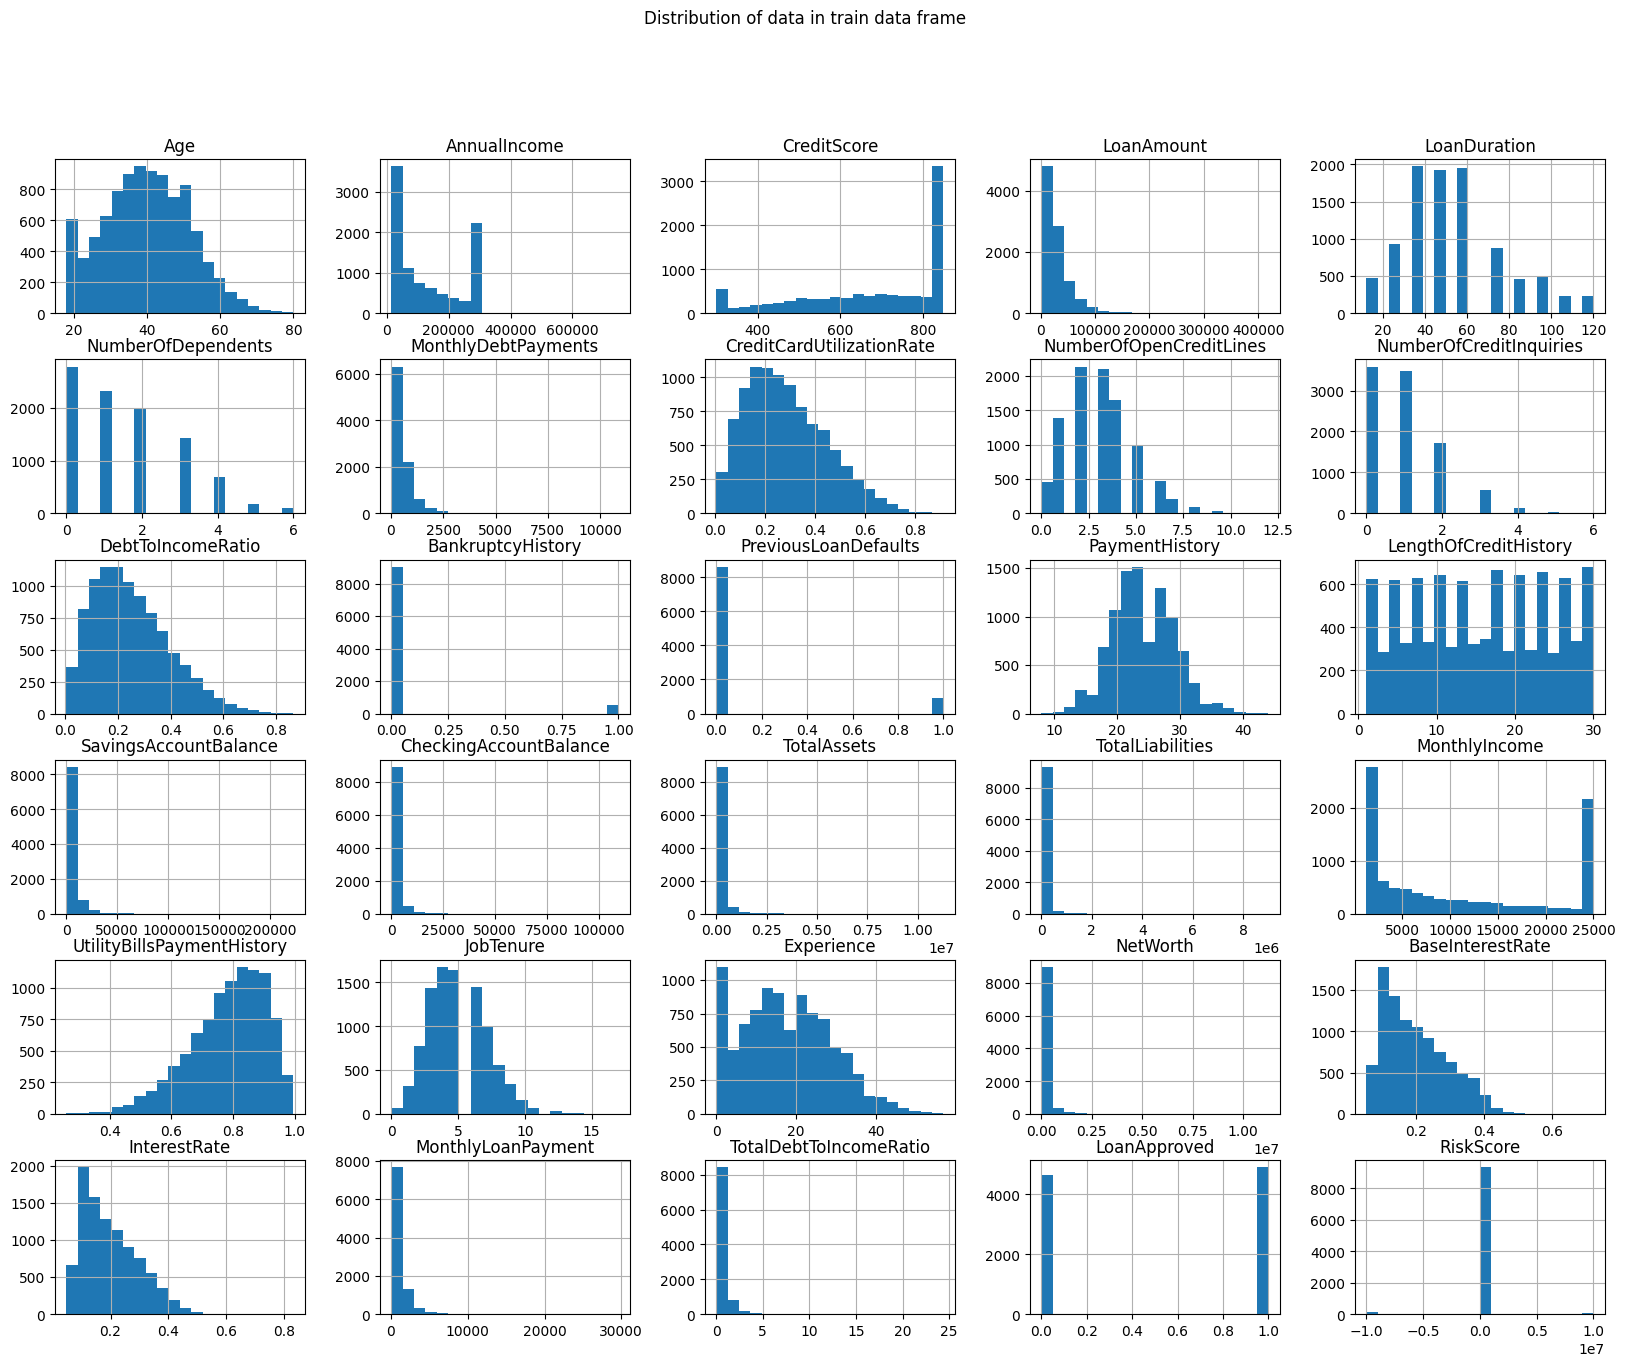

In [27]:
train_df.hist(bins=20, figsize=(20, 15))
plt.suptitle('Distribution of data in train data frame')
plt.show()

Посмотрим на наш таргет, его распределение

In [28]:
train_df['LoanApproved'].value_counts()

,count
LoanApproved,
1.000000,4891
0.000000,4638


Он принимает только два значение, их можно интерпретировать как True или False - одобрен кредит или нет

In [29]:
train_df = train_df[
    (train_df['RiskScore']<100) & (train_df['RiskScore']>0)
    ]

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             9332 non-null   object 
 1   Age                         9332 non-null   float64
 2   AnnualIncome                9332 non-null   float64
 3   CreditScore                 9332 non-null   float64
 4   LoanAmount                  9332 non-null   float64
 5   LoanDuration                9332 non-null   float64
 6   MaritalStatus               9332 non-null   object 
 7   NumberOfDependents          9332 non-null   float64
 8   HomeOwnershipStatus         9332 non-null   object 
 9   MonthlyDebtPayments         9332 non-null   float64
 10  CreditCardUtilizationRate   9332 non-null   float64
 11  NumberOfOpenCreditLines     9332 non-null   float64
 12  NumberOfCreditInquiries     9332 non-null   float64
 13  DebtToIncomeRatio           9332 non-n

Применим OneHot и Label Encoding

In [31]:
train_df.select_dtypes(include=['object']).columns

print(train_df.select_dtypes(include=['object']).columns)

train_df = pd.get_dummies(
    train_df,
    columns=[
        'MaritalStatus',
        'HomeOwnershipStatus',
        'EmploymentStatus',
        'LoanPurpose'
        ],
    drop_first=True
    )

train_df

Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')


,ApplicationDate,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,HomeOwnershipStatus_Other,HomeOwnershipStatus_Own,HomeOwnershipStatus_Rent,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,2010-06-26,27.000000,66829.000000,549.000000,17290.000000,60.000000,1.000000,1095.000000,0.151985,2.000000,1.000000,0.168542,0.000000,0.000000,23.000000,5.000000,2539.000000,247.000000,50072.000000,15005.000000,5569.083333,0.908289,4.000000,Associate,4.000000,35067.000000,0.257790,0.251465,508.970230,0.288013,0.000000,66.176500,False,False,False,False,False,True,False,False,False,True,False,False
1,1996-09-23,55.000000,172147.000000,850.000000,16110.000000,36.000000,1.000000,211.000000,0.175693,3.000000,0.000000,0.141553,0.000000,0.000000,27.000000,11.000000,844.000000,694.000000,91878.000000,64877.000000,14345.583333,0.797339,2.000000,High School,33.000000,27001.000000,0.086110,0.093173,514.675859,0.050585,1.000000,28.495737,False,False,True,False,False,False,False,False,False,False,True,False
2,2015-01-19,51.000000,300000.000000,850.000000,38436.000000,36.000000,0.000000,546.000000,0.444605,3.000000,0.000000,0.030987,1.000000,0.000000,21.000000,12.000000,12756.000000,651.000000,292300.000000,13918.000000,25000.000000,0.915945,3.000000,Bachelor,28.000000,278382.000000,0.108436,0.115443,1268.276385,0.072571,1.000000,34.488104,True,False,False,False,False,False,False,False,False,True,False,False
3,1981-05-12,25.000000,34683.000000,847.000000,19186.000000,48.000000,0.000000,153.000000,0.188452,7.000000,0.000000,0.379843,0.000000,0.000000,27.000000,21.000000,1524.000000,529.000000,13070.000000,3846.000000,2890.250000,0.876416,3.000000,High School,0.000000,9224.000000,0.100686,0.112822,498.505187,0.225415,1.000000,36.910753,True,False,False,True,False,False,False,False,True,False,False,False
4,1995-05-07,55.000000,300000.000000,850.000000,30437.000000,48.000000,2.000000,562.000000,0.273431,3.000000,1.000000,0.068659,0.000000,0.000000,35.000000,9.000000,1973.000000,128.000000,33357.000000,351603.000000,25000.000000,0.888689,5.000000,Bachelor,31.000000,4502.000000,0.110437,0.089037,756.035156,0.052721,1.000000,31.347091,False,True,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1986-11-30,31.000000,300000.000000,850.000000,14503.000000,60.000000,2.000000,185.000000,0.056431,4.000000,0.000000,0.111624,0.000000,0.000000,20.000000,3.000000,1661.000000,1036.000000,18926.000000,78720.000000,25000.000000,0.858575,4.000000,Doctorate,10.000000,6992.000000,0.104503,0.113622,317.956385,0.020118,1.000000,34.037970,True,False,False,False,False,False,False,False,True,False,False,False
9995,1995-06-09,27.000000,15000.000000,361.000000,19505.000000,36.000000,1.000000,622.000000,0.409411,2.000000,1.000000,0.338705,0.000000,1.000000,27.000000,16.000000,5427.000000,6653.000000,47008.000000,15662.000000,1250.000000,0.881564,5.000000,High School,2.000000,31346.000000,0.334005,0.346203,878.142786,1.200114,0.000000,76.185933,False,True,False,True,False,False,False,False,False,True,False,False
9996,2000-03-10,49.000000,185082.000000,573.000000,7447.000000,84.000000,0.000000,946.000000,0.095426,0.000000,0.000000,0.050347,0.000000,0.000000,19.000000,26.000000,1

In [32]:
train_df = train_df.drop(columns='RiskScore')
train_df = train_df.drop(columns=['ApplicationDate'])

In [33]:
y_unscaled = train_df['LoanApproved']

train_df = train_df.drop(columns='LoanApproved')

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


le = LabelEncoder()
print(train_df['EducationLevel'].value_counts())


def transform(x):
    if x == 'High School':
        return 'A'
    elif x == 'Bachelor':
        return 'B'
    elif x == 'Associate':
        return 'C'
    elif x == 'Master':
        return 'D'
    elif x == 'Doctorate':
        return 'E'
    else:
        return 'A'


train_df['EducationLevel'] = train_df['EducationLevel'].apply(transform)

train_df['EducationLevel'] = le.fit_transform(train_df['EducationLevel'])

EducationLevel
High School    3758
Bachelor       2751
Associate      1836
Master          677
Doctorate       310
Name: count, dtype: int64


Наиболее важным для нас является Doctorate, так как он встречается меньше всего

In [37]:
scaler_minmax =  StandardScaler()

df_ariphmetic = train_df.select_dtypes(include=['float64','int64'])

print(df_ariphmetic)

df_other = train_df.select_dtypes(include=['object', 'bool'])

df_ariphmetic  = pd.DataFrame(
    scaler_minmax.fit_transform(df_ariphmetic),
    columns=df_ariphmetic.columns,
    index=df_ariphmetic.index
    )

train_df = pd.concat([df_ariphmetic, df_other], axis=1)

train_df

           Age  AnnualIncome  CreditScore   LoanAmount  LoanDuration  \
0    27.000000  66829.000000   549.000000 17290.000000     60.000000   
1    55.000000 172147.000000   850.000000 16110.000000     36.000000   
2    51.000000 300000.000000   850.000000 38436.000000     36.000000   
3    25.000000  34683.000000   847.000000 19186.000000     48.000000   
4    55.000000 300000.000000   850.000000 30437.000000     48.000000   
...        ...           ...          ...          ...           ...   
9994 31.000000 300000.000000   850.000000 14503.000000     60.000000   
9995 27.000000  15000.000000   361.000000 19505.000000     36.000000   
9996 49.000000 185082.000000   573.000000  7447.000000     84.000000   
9997 55.000000 296728.000000   850.000000 44162.000000     84.000000   
9999 28.000000  87240.000000   649.000000 14901.000000     12.000000   

      NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
0               1.000000          1095.000000              

,Age,AnnualIncome,CreditScore,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,NumberOfCreditInquiries,DebtToIncomeRatio,BankruptcyHistory,PreviousLoanDefaults,PaymentHistory,LengthOfCreditHistory,SavingsAccountBalance,CheckingAccountBalance,TotalAssets,TotalLiabilities,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,EducationLevel,Experience,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,HomeOwnershipStatus_Other,HomeOwnershipStatus_Own,HomeOwnershipStatus_Rent,EmploymentStatus_Self-Employed,EmploymentStatus_Unemployed,LoanPurpose_Debt Consolidation,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other
0,-1.111860,-0.558666,-0.736675,-0.458262,0.271045,-0.399683,1.088754,-0.834293,-0.592693,0.020501,-0.564190,-0.234647,-0.326303,-0.207674,-1.227355,-0.351506,-0.570983,-0.284925,-0.264240,-0.561439,1.005567,-0.430758,0.882217,-1.206176,-0.257881,0.611353,0.536502,-0.430454,-0.263863,False,False,False,False,False,True,False,False,False,True,False,False
1,1.305009,0.349116,0.981312,-0.501464,-0.712006,-0.399683,-0.667339,-0.685576,-0.017923,-0.991767,-0.750923,-0.234647,-0.326303,0.617013,-0.534250,-0.552032,-0.423819,-0.194328,-0.019549,0.373730,0.108194,-1.336739,-0.953423,1.355949,-0.275565,-1.212958,-1.110127,-0.426096,-0.544278,False,False,True,False,False,False,False,False,False,False,True,False
2,0.959742,1.451138,0.981312,0.315946,-0.712006,-1.105025,-0.001851,1.001318,-0.017923,-0.991767,-1.515888,4.261715,-0.326303,-0.620017,-0.418732,0.857206,-0.437975,0.240003,-0.269573,1.508998,1.067496,-0.883749,-0.035603,0.914203,0.275573,-0.975717,-0.878457,0.149478,-0.518312,True,False,False,False,False,False,False,False,False,True,False,False
3,-1.284494,-0.835746,0.964189,-0.388844,-0.220481,-1.105025,-0.782558,-0.605538,2.281157,-0.991767,0.897726,-0.234647,-0.326303,0.617013,0.620925,-0.471585,-0.478141,-0.365112,-0.318990,-0.846878,0.747782,-0.883749,-0.953423,-1.559573,-0.314540,-1.058070,-0.905731,-0.438447,-0.337795,True,False,False,True,False,False,False,False,True,False,False,False
4,1.305009,1.451138,0.981312,0.023083,-0.220481,0.305658,0.029933,-0.072460,-0.017923,0.020501,-1.255248,-0.234647,-0.326303,2.266386,-0.765285,-0.418466,-0.610161,-0.321148,1.387237,1.508998,0.847040,0.022232,-0.035603,1.179251,-0.324893,-0.954454,-1.153148,-0.241754,-0.541755,False,True,False,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,-0.766593,1.451138,0.981312,-0.560301,0.271045,0.305658,-0.718989,-1.433705,0.556847,-0.991767,-0.957989,-0.234647,-0.326303,-0.826189,-1.458389,-0.455377,-0.311223,-0.352421,0.048370,1.508998,0.603478,-0.430758,2.717857,-0.676081,-0.319434,-1.017510,-0.897404,-0.576343,-0.580261,True,False,False,False,False,False,False,False,True,False,False,False
9995,-1.111860,-1.005403,-1.809704,-0.377165,-0.712006,-0.399683,0.149125,0.780542,-0.592693,0.020501,0.613107,-0.234647,3.064634,0.617013,0.043338,-0.009844,1.538039,-0.291565,-0.261016,-1.021653,0.789418,0.022232,-0.953423,-1.382874,-0.266039,1.421231,1.522017,-0.148493,0.813375,False,True,False,True,False,False,False,False,False,True,False,False
9996,0.787109,0.460609,-0.599693,-0.818638,1.254095,-1.105025,0.792761,-1.189089,-1.742233,-0.991767,-1.381940,-0.234647,-0.326303,-1.032361,1.198512,0.775577,0.184920,-0.272209,-0.132165,0.488586,0.593353,-0.430758,-0.953423,0.825854,-0.304034,0.591769,0.365795,-0.680611,-0.517689,True,False,False,False,False,False,False,False,False,False,False,False
9997,1.305009,1.422935,0.981312,0.525589,1.254095,0.305658,-0.134949,0.557179,1.706387,-0.991767,0.781590,4.261715,-0.326303,-0.413846,0.389890,1.232822,0.619499,-0.350540,0.679801,1.479944,0.309467,-0.430758,-0.953423,1.355949,-

Посмотрим на HeatMap

In [38]:
heat_map = train_df.corr()

plt.figure(figsize=(120, 80))
sns.heatmap(heat_map, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Heat Map")
plt.show()

Посмотрим на значения с высокой теплотой

In [39]:
high_heat = heat_map[(heat_map >= 0.8) & (heat_map != 1.)].stack()

print(high_heat)

Age                 Experience           0.982802
AnnualIncome        MonthlyIncome        0.984441
LoanAmount          MonthlyLoanPayment   0.868404
TotalAssets         NetWorth             0.993819
MonthlyIncome       AnnualIncome         0.984441
Experience          Age                  0.982802
NetWorth            TotalAssets          0.993819
BaseInterestRate    InterestRate         0.975215
InterestRate        BaseInterestRate     0.975215
MonthlyLoanPayment  LoanAmount           0.868404
dtype: float64


In [40]:
train_df = train_df.drop(
    columns=[
        'Age',
        'InterestRate',
        'TotalAssets',
        'LoanAmount',
        'AnnualIncome'
        ],
    inplace=False
    )

In [41]:
y = y_unscaled
train_df = train_df.astype({col: 'int' for col in train_df.select_dtypes(include=['bool']).columns})
X = train_df

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9332 entries, 0 to 9999
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CreditScore                     9332 non-null   float64
 1   LoanDuration                    9332 non-null   float64
 2   NumberOfDependents              9332 non-null   float64
 3   MonthlyDebtPayments             9332 non-null   float64
 4   CreditCardUtilizationRate       9332 non-null   float64
 5   NumberOfOpenCreditLines         9332 non-null   float64
 6   NumberOfCreditInquiries         9332 non-null   float64
 7   DebtToIncomeRatio               9332 non-null   float64
 8   BankruptcyHistory               9332 non-null   float64
 9   PreviousLoanDefaults            9332 non-null   float64
 10  PaymentHistory                  9332 non-null   float64
 11  LengthOfCreditHistory           9332 non-null   float64
 12  SavingsAccountBalance           9332 no

Нормализуем данные

In [42]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Сделаем предсказание на тестовых данных

In [43]:
logistic_model = LinearAndLogisticClassifier(learning_rate=0.01, n_iterations=1000, logistic=True)
logistic_model.fit(X_train_scaled, y_train)


y_pred_logistic = logistic_model.predict(X_test_scaled)

Сделаем визуализацию метрик

In [46]:
def visualize_metrics(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Accuracy': accuracy
    }

    print(f"Metrics for {model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    return metrics

Посмотрим на метрики

## My Logistic Regression

Metrics for My Logistic Regression:
  Precision: 0.8734
  Recall: 0.9062
  F1-Score: 0.8895
  Accuracy: 0.8862


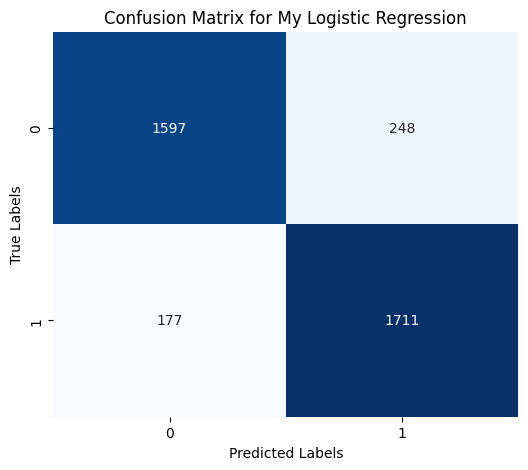

{'Precision': 0.8734047983665135,
 'Recall': 0.90625,
 'F1-Score': 0.8895243046529764,
 'Accuracy': 0.8861505491561746}

In [52]:
visualize_metrics(y_test, y_pred_logistic, "My Logistic Regression")

## My Linear Classificator

Metrics for My Linear Classificator:
  Precision: 0.9374
  Recall: 0.8490
  F1-Score: 0.8911
  Accuracy: 0.8950


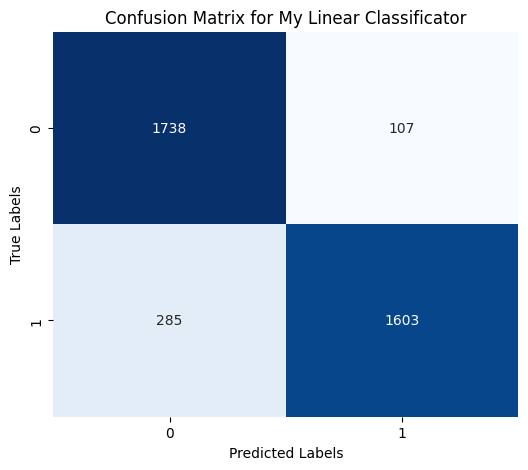

{'Precision': 0.9374269005847953,
 'Recall': 0.8490466101694916,
 'F1-Score': 0.8910505836575876,
 'Accuracy': 0.8949906241628717}

In [53]:
linear_regression_model = LinearAndLogisticClassifier(learning_rate=0.01, n_iterations=1000, logistic=False)
linear_regression_model.fit(X_train_scaled, y_train)

y_pred_linear_regression = linear_regression_model.predict(X_test_scaled)

visualize_metrics(y_test, y_pred_linear_regression, "My Linear Classificator")

## Sklearn Linear Classificator

Metrics for Sklearn Linear Classificator:
  Precision: 0.9215
  Recall: 0.9322
  F1-Score: 0.9268
  Accuracy: 0.9255


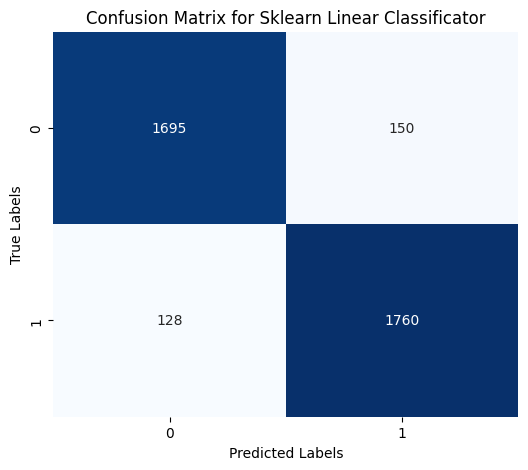

{'Precision': 0.9214659685863874,
 'Recall': 0.9322033898305084,
 'F1-Score': 0.9268035808320169,
 'Accuracy': 0.9255290650950978}

In [54]:
model_log_reg_sklearn = LogisticRegression()
model_log_reg_sklearn.fit(X_train_scaled, y_train)

y_pred_log_reg_sklearn = model_log_reg_sklearn.predict(X_test_scaled)

visualize_metrics(y_test, y_pred_log_reg_sklearn, "Sklearn Linear Classificator")

## SVC

Metrics for SVC Sklearn:
  Precision: 0.9216
  Recall: 0.9089
  F1-Score: 0.9152
  Accuracy: 0.9148


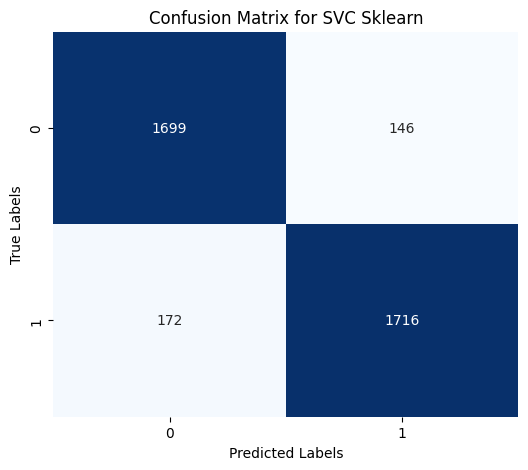

{'Precision': 0.9215896885069818,
 'Recall': 0.9088983050847458,
 'F1-Score': 0.9152,
 'Accuracy': 0.9148138226627377}

In [72]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_scaled, y_train)
y_pred_svm = svc.predict(X_test_scaled)

visualize_metrics(y_test, y_pred_svm, "SVC Sklearn")

## Decision Tree Classificator

Metrics for Decision Tree Classificator:
  Precision: 0.8790
  Recall: 0.8851
  F1-Score: 0.8820
  Accuracy: 0.8803


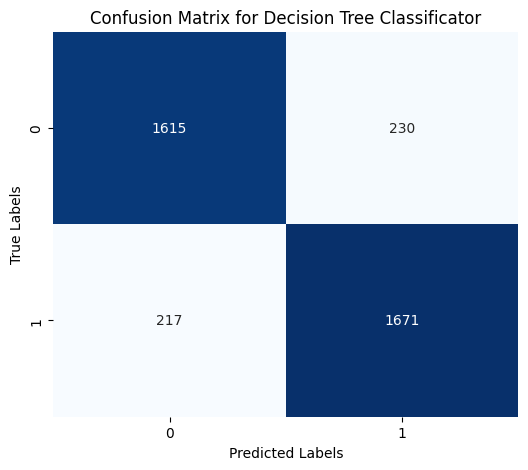

{'Precision': 0.8790110468174644,
 'Recall': 0.8850635593220338,
 'F1-Score': 0.8820269200316706,
 'Accuracy': 0.8802571658183767}

In [61]:
model_DecisionTreeClassifier = DecisionTreeClassifier()
model_DecisionTreeClassifier.fit(X_train, y_train)

y_pred_model_DecisionTreeClassifier = model_DecisionTreeClassifier.predict(X_test)

visualize_metrics(y_test, y_pred_model_DecisionTreeClassifier, "Decision Tree Classificator")

## Random Forest Classificator

Metrics for Random Forest Classificator:
  Precision: 0.9126
  Recall: 0.9237
  F1-Score: 0.9181
  Accuracy: 0.9167


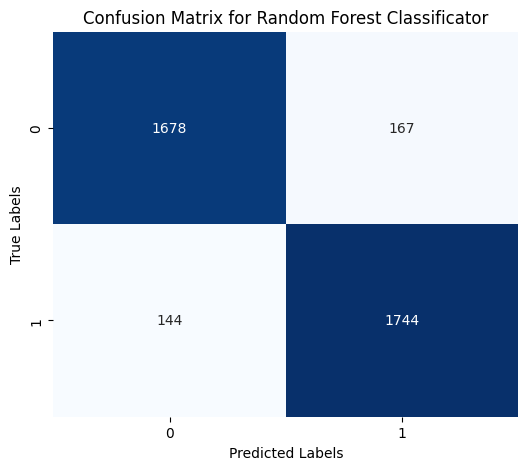

{'Precision': 0.912611198325484,
 'Recall': 0.923728813559322,
 'F1-Score': 0.9181363516714925,
 'Accuracy': 0.9166889900884008}

In [71]:
model_RandomForestClassifier = RandomForestClassifier()
model_RandomForestClassifier.fit(X_train, y_train)

y_pred_model_RandomForestClassifier = model_RandomForestClassifier.predict(X_test)

visualize_metrics(y_test, y_pred_model_RandomForestClassifier, "Random Forest Classificator")

## Boosting

Metrics for Sklearn Gradient Boosting:
  Precision: 0.9216
  Recall: 0.9274
  F1-Score: 0.9245
  Accuracy: 0.9234


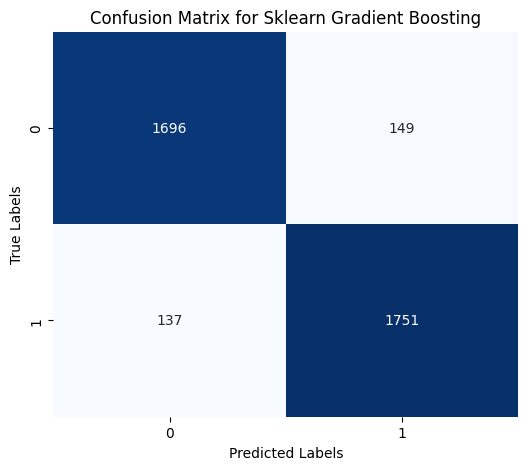

{'Precision': 0.921578947368421,
 'Recall': 0.9274364406779662,
 'F1-Score': 0.9244984160506864,
 'Accuracy': 0.9233860166086257}

In [64]:
sklearn_gb_model = GradientBoostingClassifier(random_state=42)
sklearn_gb_model.fit(X_train, y_train)

y_pred_sklearn_gb = sklearn_gb_model.predict(X_test)

visualize_metrics(y_test, y_pred_sklearn_gb, "Sklearn Gradient Boosting")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2901, number of negative: 2698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001268 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3505
[LightGBM] [Info] Number of data points in the train set: 5599, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.518128 -> initscore=0.072545
[LightGBM] [Info] Start training from score 0.072545
Metrics for LightGBM:
  Precision: 0.9173
  Recall: 0.9338
  F1-Score: 0.9255
  Accuracy: 0.9239


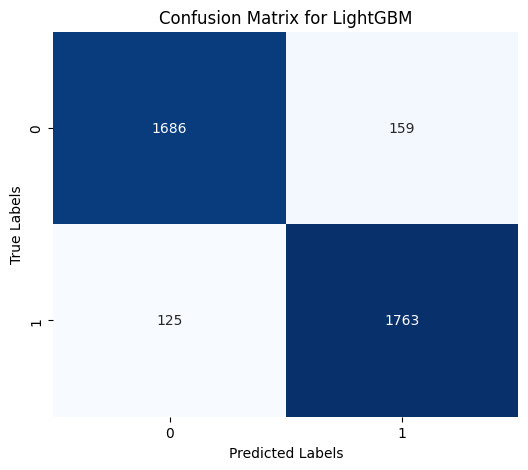

{'Precision': 0.9172736732570239,
 'Recall': 0.933792372881356,
 'F1-Score': 0.9254593175853019,
 'Accuracy': 0.9239217787302437}

In [66]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

visualize_metrics(y_test, y_pred_lgb, "LightGBM")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:58:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Metrics for XGBoost:
  Precision: 0.9159
  Recall: 0.9285
  F1-Score: 0.9221
  Accuracy: 0.9207


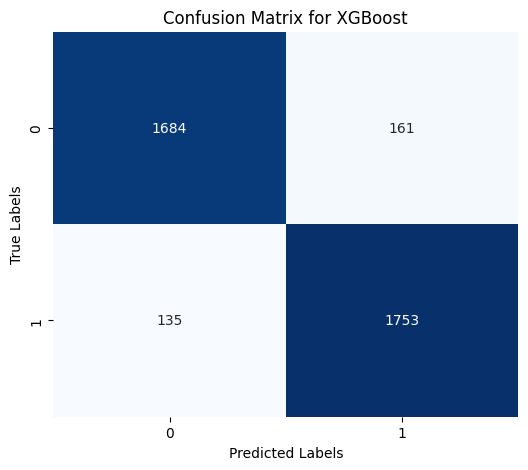

{'Precision': 0.9158829676071055,
 'Recall': 0.9284957627118644,
 'F1-Score': 0.9221462388216728,
 'Accuracy': 0.9207072060005358}

In [67]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

visualize_metrics(y_test, y_pred_xgb, "XGBoost")

Metrics for CatBoost:
  Precision: 0.9215
  Recall: 0.9322
  F1-Score: 0.9268
  Accuracy: 0.9255


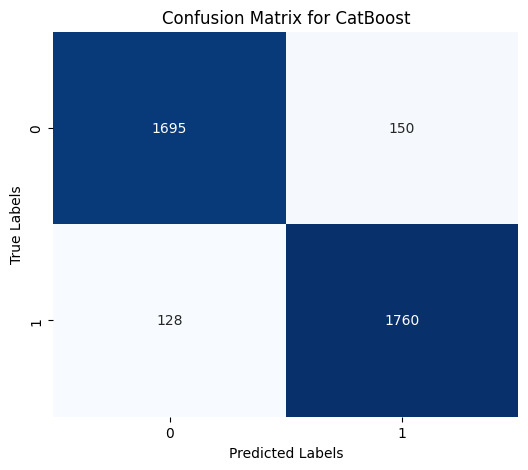

{'Precision': 0.9214659685863874,
 'Recall': 0.9322033898305084,
 'F1-Score': 0.9268035808320169,
 'Accuracy': 0.9255290650950978}

In [68]:
catboost_model = CatBoostClassifier(random_state=42, verbose=0)
catboost_model.fit(X_train, y_train)

y_pred_catboost = catboost_model.predict(X_test)

visualize_metrics(y_test, y_pred_catboost, "CatBoost")

## Naive Bayes

Metrics for Naive Bayes:
  Precision: 0.8321
  Recall: 0.9296
  F1-Score: 0.8782
  Accuracy: 0.8695


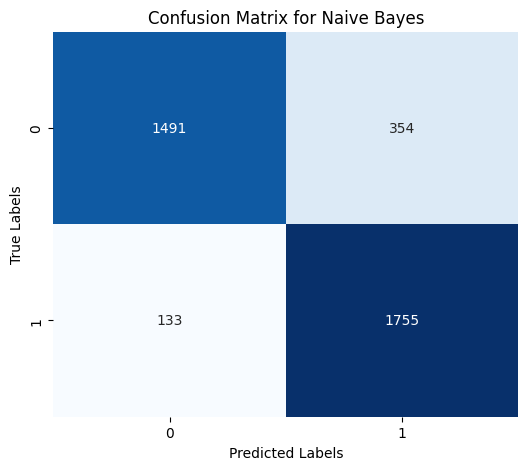

{'Precision': 0.8321479374110953,
 'Recall': 0.9295550847457628,
 'F1-Score': 0.8781586189642232,
 'Accuracy': 0.8695419233860167}

In [69]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

visualize_metrics(y_test, y_pred_nb, "Naive Bayes")

## KNN

Metrics for K-Nearest Neighbors (KNN):
  Precision: 0.8302
  Recall: 0.8782
  F1-Score: 0.8535
  Accuracy: 0.8476


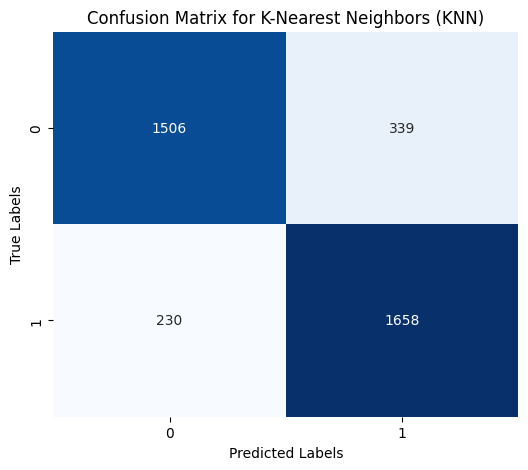

{'Precision': 0.8302453680520782,
 'Recall': 0.878177966101695,
 'F1-Score': 0.8535392535392535,
 'Accuracy': 0.8475756763996786}

In [70]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Предсказание на тестовых данных (KNN)
y_pred_knn = knn_model.predict(X_test)

visualize_metrics(y_test, y_pred_knn, "K-Nearest Neighbors (KNN)")

## **Вывод**

Для предсказания мы использовали 10 различных моделей:

* Logictic Regression (sklearn)
* LogisticRegression (моя)
* SVC (sklearn)
* Решающее дерево (sklearn)
* Случайный лес (sklearn)
* Градиентный бустинг (sklearn)
* Градиентный бустинг (LightGBM)
* Градиентный бустинг (XGBoost)
* Градиентный бустинг (catboost)

Лучше всего себя поазали Logistic Regression, catboost, XGBoost, LightGBM. Хуже всего себя показало DecisionTree. Это произошло из-за линейной разделимости нашего датасета, а также то, что при его обучении не было выставлено ограничение глубины , и оно переобучилось, подстроившись под тренировочные данные. Остальные модели показали в целом одинаковый достойный результат, с достаточной точностью

Ну и ожидаемо, самописные классы показали себя не очень достойно, уступив готовым библиотечным решениям

Из бустингов победителем вышел catboost, благодаря своим оптимизациям и эффективным алгоритмам

Показатель F1 был наиболее информативным показателем, поскольку он обеспечивает баланс между точностью и запоминанием, что имеет решающее значение для задач бинарной классификации